In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
eth= pd.read_csv("C:\\Users\\Nikhil\\Downloads\\eth daily data.csv", parse_dates=['Date'])
eth.set_index('Date', drop=True, inplace=True)

In [3]:
eth.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2015-08-08,1,Ethereum,ETH,2.798810,0.714725,2.793760,0.753325,674188,45486894.24
2015-09-08,2,Ethereum,ETH,0.879810,0.629191,0.706136,0.701897,532170,42399573.50
2015-10-08,3,Ethereum,ETH,0.729854,0.636546,0.713989,0.708448,405283,42818364.39
2015-11-08,4,Ethereum,ETH,1.131410,0.663235,0.708087,1.067860,1463100,64569288.43
2015-12-08,5,Ethereum,ETH,1.289940,0.883608,1.058750,1.217440,2150620,73645010.99


In [4]:
eth.drop(['SNo','Name','Symbol','Volume','Marketcap'],inplace=True,axis=1)

In [5]:
eth.head()

,High,Low,Open,Close
Date,,,,
2015-08-08,2.798810,0.714725,2.793760,0.753325
2015-09-08,0.879810,0.629191,0.706136,0.701897
2015-10-08,0.729854,0.636546,0.713989,0.708448
2015-11-08,1.131410,0.663235,0.708087,1.067860
2015-12-08,1.289940,0.883608,1.058750,1.217440


In [6]:
# Resampling to monthly frequency
eth_month = eth.resample('M').mean()

#Stationarity check and Seasonal decomposition 
If a time series is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

Dickey–Fuller test: p=0.909543


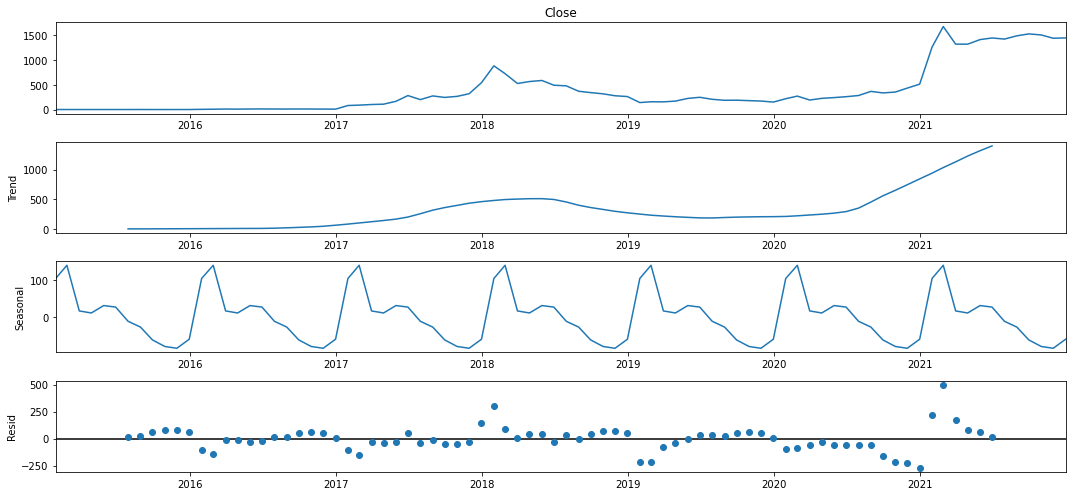

In [7]:
#seasonal_decompose(eth_month.close, freq=12).plot()
seasonal_decompose(eth_month.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.Close)[1])
plt.show()
#The p-value indicates that series is not stationary with 90.95% confidence.



Box-Cox Transformation 
Lets use the Box-Cox transformation to suppress some of the variance.

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a non-constant variance. if the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p an q for the ARMA model, the AR and MA parameters can then be estimated.


In [8]:
# Box-Cox Transformations
eth_month['Close_box'], lmbda = stats.boxcox(eth_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.Close_box)[1])
#The p-value indicates that series is still not stationary.

Dickey–Fuller test: p=0.809674


Differencing 
When building models to forecast time series data (like ARIMA), another pre-processing step is differencing the data (calculating sequentially xt−xt−1) until we get to a point where the series is stationary. Models account for oscillations but not for trends, and therefore, accounting for trends by differencing allows us to use the models that account for oscillations.

Once the model has been constructed, we can account for trends separately, by adding the trends component-wise.

Seasonal differentiation 
One method of differencing data is seasonal differencing, which involves computing the difference between an observation and the corresponding observation in the previous year.

In [9]:
# Seasonal differentiation (12 months)
eth_month['box_diff_seasonal_12'] = eth_month.Close_box - eth_month.Close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.box_diff_seasonal_12[12:])[1])
#The p-value indicates that series is still not stationary.

Dickey–Fuller test: p=0.213739


In [10]:
# Seasonal differentiation (9 months)
eth_month['box_diff_seasonal_9'] = eth_month.Close_box - eth_month.Close_box.shift(9)
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.box_diff_seasonal_9[9:])[1])
#The p-value indicates that series is still not stationary.

Dickey–Fuller test: p=0.377358


In [11]:
# Seasonal differentiation (3 months)
eth_month['box_diff_seasonal_3'] = eth_month.Close_box - eth_month.Close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.176523


Dickey–Fuller test: p=0.002957


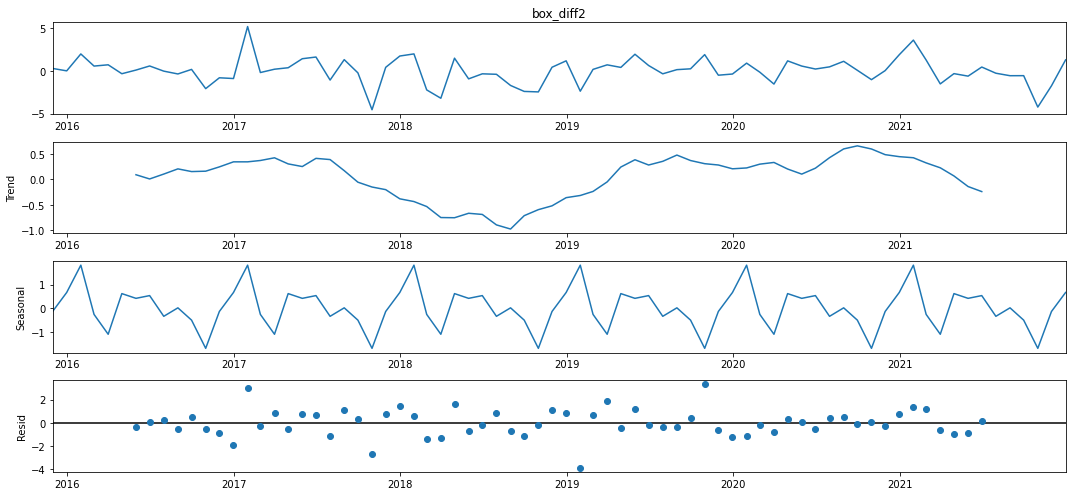

In [12]:
# Regular differentiation
eth_month['box_diff2'] = eth_month.box_diff_seasonal_9 - eth_month.box_diff_seasonal_9.shift(1)

# STL-decomposition
seasonal_decompose(eth_month.box_diff2[10:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.box_diff2[10:])[1])

plt.show()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

# Autocorrelation 
Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals.

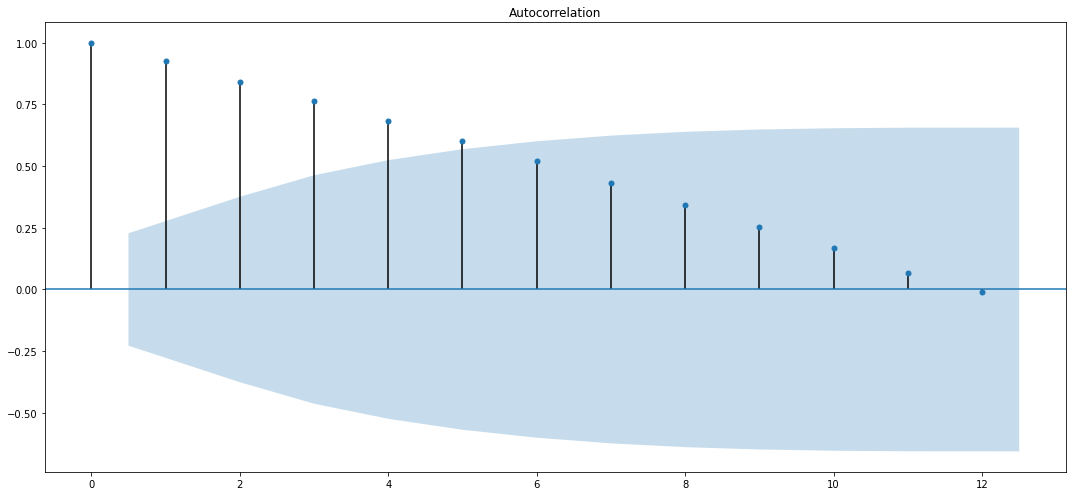

In [13]:
#autocorrelation_plot(btc_month.close)
plot_acf(eth_month.Close[10:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

There is a positive correlation with the first 11 lags that is perhaps significant for the first 2-3 lags.

A good starting point for the AR parameter of the model may be 3.

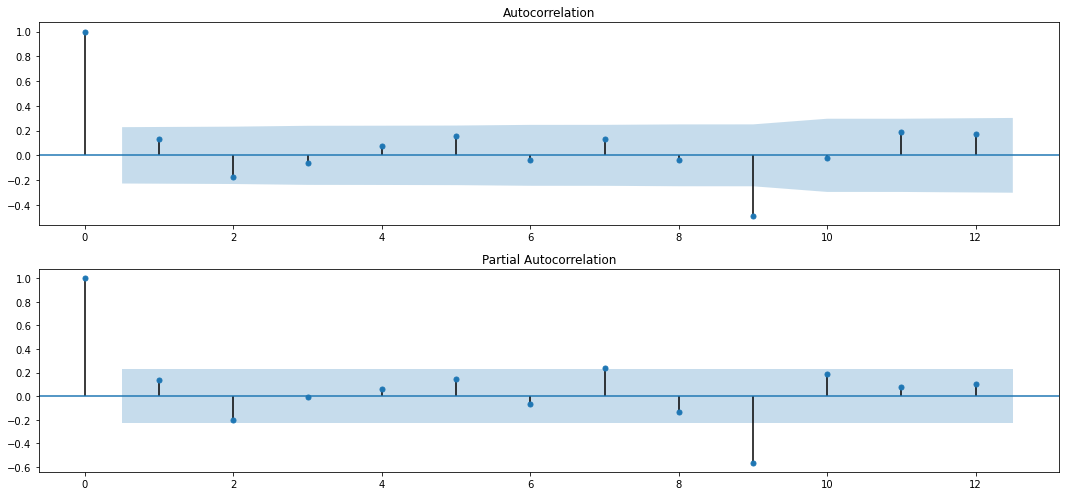

In [14]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(eth_month.box_diff2[10:].values.squeeze(), lags=48, ax=ax)
plot_acf(eth_month.box_diff2[10:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(eth_month.box_diff2[10:].values.squeeze(), lags=48, ax=ax)
plot_pacf(eth_month.box_diff2[10:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models.

There may be a seasonal component available in the residuals at the lags of quarters (3 months) represented by spikes at these intervals. But probably not significant.

# ARIMA Model 
AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:

p - the number of lag observations to include in the model, or lag order. (AR)
d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
q - the size of the moving average window, also called the order of moving average.(MA)

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates to not use that element of the model.
Parameter Selection
We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [15]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(eth_month.Close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [16]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
1     (0, 1)  239.602891
3     (1, 0)  239.701374
0     (0, 0)  239.757023
4     (1, 1)  241.586180
2     (0, 2)  241.590017


In [17]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Close_box   No. Observations:                   84
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -117.801
Date:                Mon, 05 Jul 2021   AIC                            239.603
Time:                        04:18:23   BIC                            244.441
Sample:                    01-31-2015   HQIC                           241.546
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1633      0.128      1.280      0.200      -0.087       0.413
sigma2         1.0004      0.070     14.362      0.000       0.864       1.137
Ljung-Box (Q):                       37.16   Jarque-

Analysis of Results 
The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

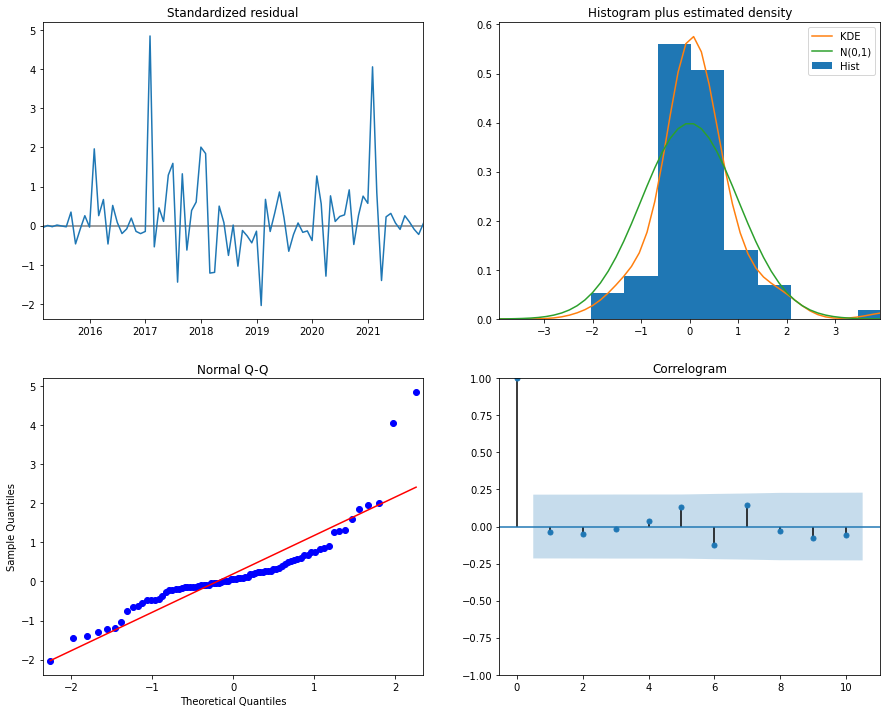

In [18]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the histogram (top right), the KDE line should follow the N(0,1) line (normal distribution with mean 0, standard deviation 1) closely. This is an indication whether the residuals are normally distributed or not.

In the Q-Q-plot the ordered distribution of residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is an indication whether the residuals are normally distributed.

The standardized residual plot doesn't display any obvious seasonality. 
This is confirmed by the autocorrelation plot, which shows that the time series residuals have low correlation with lagged versions of itself.

# Prediction 

In [19]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

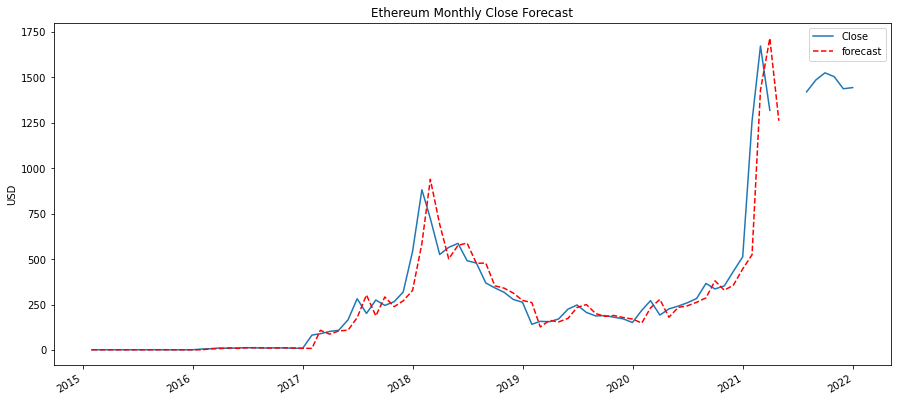

In [20]:
# Prediction
eth_month2 = eth_month[['Close']]
date_list = [datetime(2021, 3, 31), datetime(2021, 4, 30), datetime(2021, 5, 31), datetime(2021, 6, 30)]
future = pd.DataFrame(index=date_list, columns= eth_month.columns)
eth_month2 = pd.concat([eth_month2, future])

eth_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
eth_month2.Close.plot()
eth_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Ethereum Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('Ethereum_monthly_forecast.png')
plt.show()

In [42]:
y_forecasted = eth_month2.forecast
y_truth = eth_month2['2015-01-01':'2021-02-27'].Close
# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 109.48


In [22]:
btc= pd.read_csv("C:\\Users\\Nikhil\\Downloads\\bitcoin daily data.csv", parse_dates=['Date'])
btc.set_index('Date', drop=True, inplace=True)
btc.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29,1,Bitcoin,BTC,147.49,134.00,134.44,144.54,0.0,1.603769e+09
2013-04-30,2,Bitcoin,BTC,146.93,134.05,144.00,139.00,0.0,1.542813e+09
2013-01-05,3,Bitcoin,BTC,139.89,107.72,139.00,116.99,0.0,1.298955e+09
2013-02-05,4,Bitcoin,BTC,125.60,92.28,116.38,105.21,0.0,1.168517e+09
2013-03-05,5,Bitcoin,BTC,108.13,79.10,106.25,97.75,0.0,1.085995e+09


In [23]:
btc.drop(['SNo','Name','Symbol','Volume','Marketcap'],inplace=True,axis=1)

In [24]:
btc.head()

,High,Low,Open,Close
Date,,,,
2013-04-29,147.49,134.00,134.44,144.54
2013-04-30,146.93,134.05,144.00,139.00
2013-01-05,139.89,107.72,139.00,116.99
2013-02-05,125.60,92.28,116.38,105.21
2013-03-05,108.13,79.10,106.25,97.75


In [25]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

Dickey–Fuller test: p=0.990841


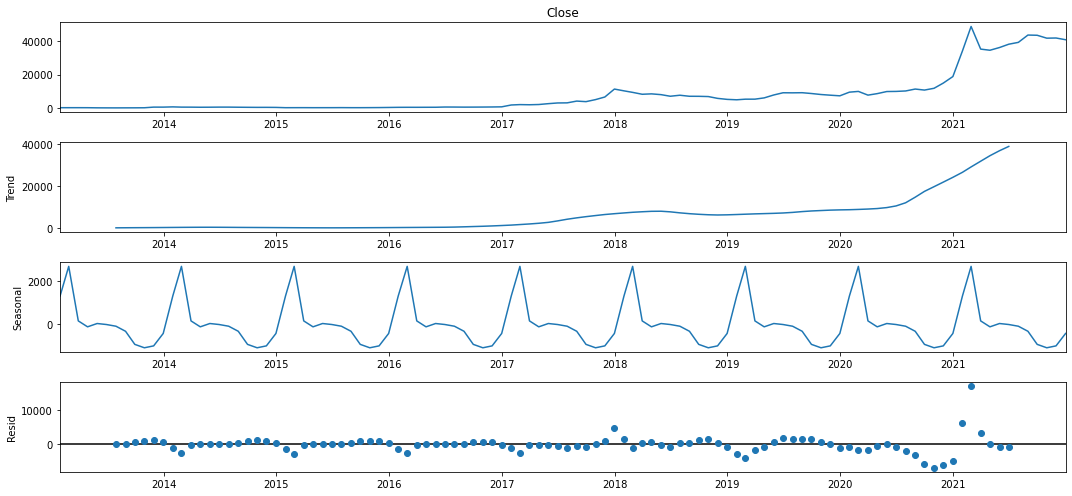

In [26]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(btc_month.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])
plt.show()
#The p-value indicates that series is not stationary with 99.08% confidence.

In [27]:
# Box-Cox Transformations
btc_month['Close_box'], lmbda = stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close_box)[1])
#The p-value indicates that series is still not stationary.

Dickey–Fuller test: p=0.902681


In [28]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.Close_box - btc_month.Close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])
#The p-value indicates that series is still not stationary.

Dickey–Fuller test: p=0.111426


In [29]:
# Seasonal differentiation (9 months)
btc_month['box_diff_seasonal_9'] = btc_month.Close_box - btc_month.Close_box.shift(9)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_9[9:])[1])
#The p-value indicates that series is still not stationary.

Dickey–Fuller test: p=0.371837


In [30]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.Close_box - btc_month.Close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.009219


Dickey–Fuller test: p=0.000368


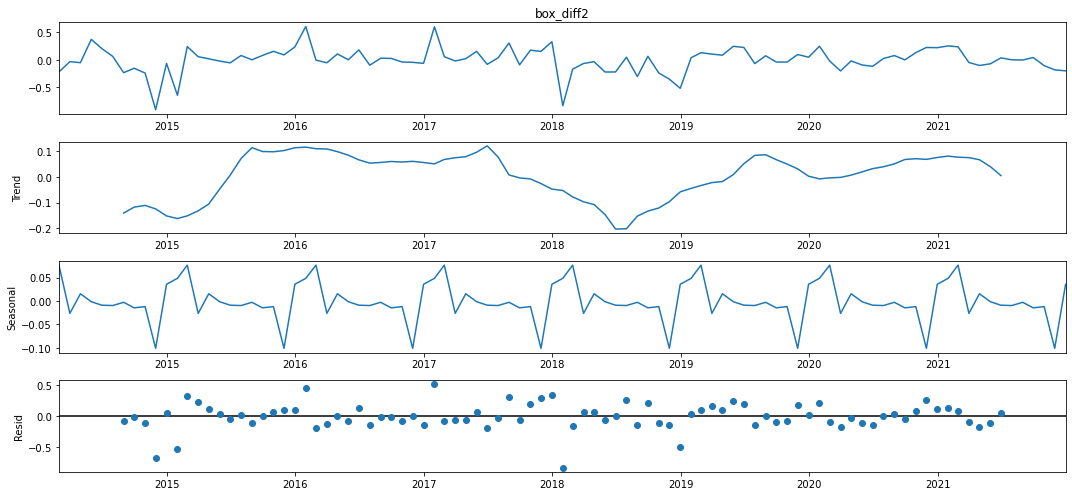

In [31]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

plt.show()

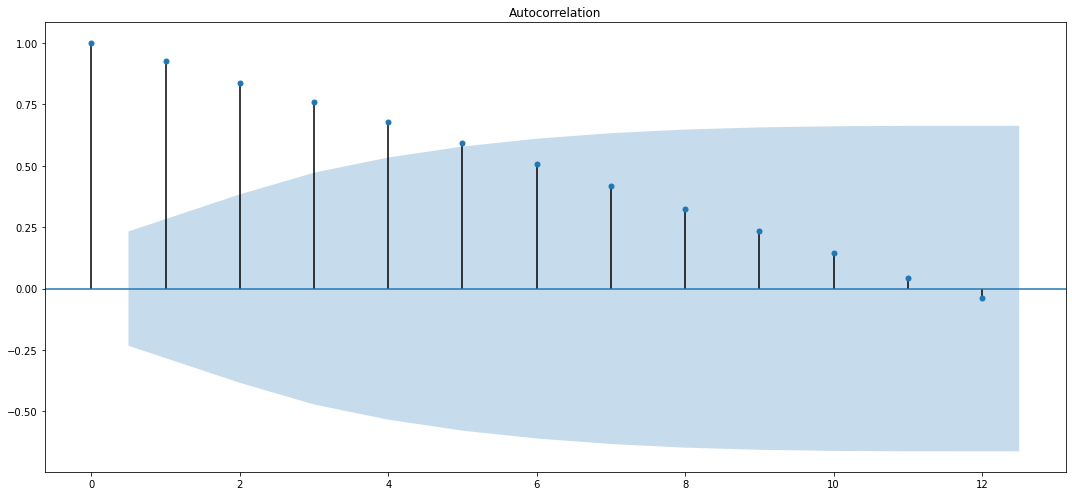

In [32]:
#autocorrelation_plot(btc_month.close)
plot_acf(eth_month.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

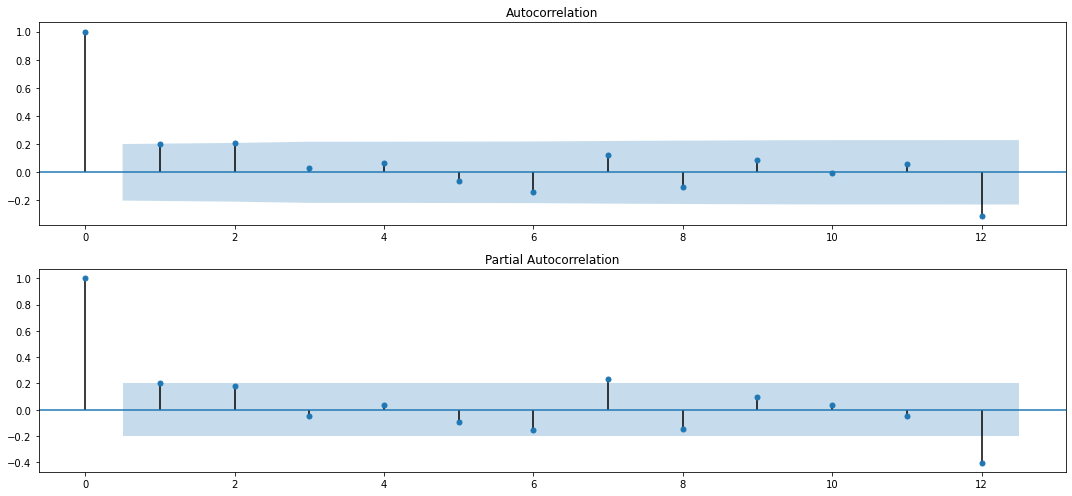

In [33]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

In [34]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.Close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [35]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
3     (1, 0) -73.915471
1     (0, 1) -72.818349
6     (2, 0) -72.465720
4     (1, 1) -72.404649
2     (0, 2) -72.346102


In [36]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Close_box   No. Observations:                  108
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  38.958
Date:                Mon, 05 Jul 2021   AIC                            -73.915
Time:                        04:18:31   BIC                            -68.570
Sample:                    01-31-2013   HQIC                           -71.748
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2428      0.090      2.685      0.007       0.066       0.420
sigma2         0.0282      0.002     15.199      0.000       0.025       0.032
Ljung-Box (Q):                       43.22   Jarque-

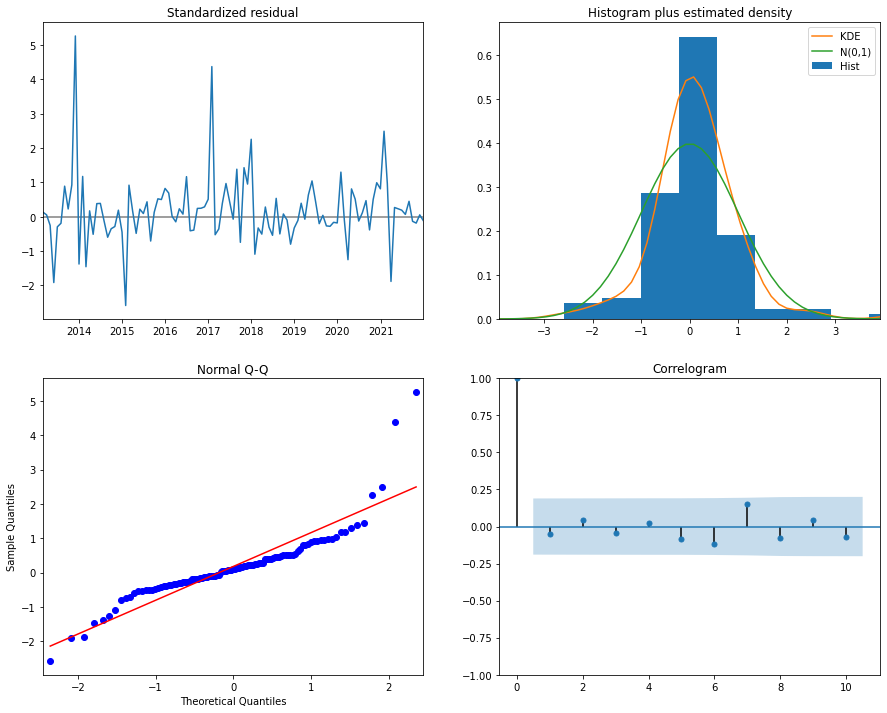

In [38]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [39]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

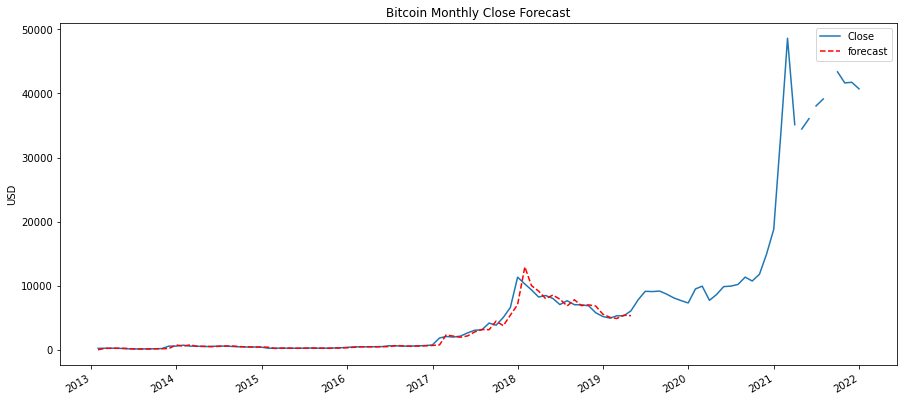

In [45]:
# Prediction
btc_month2 = btc_month[['Close']]
date_list = [datetime(2021, 3, 31), datetime(2021, 4, 30), datetime(2021, 5, 31), datetime(2021, 6, 30),datetime(2021, 7, 31), datetime(2021, 8, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
btc_month2.Close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('Bitcoin_monthly_forecast.png')
plt.show()

In [43]:
y_forecasted = btc_month2.forecast
y_truth = btc_month2['2015-01-01':'2021-02-27'].Close
# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 849.0
